<a href="https://colab.research.google.com/github/alhasanmolla/Quant-Researcher/blob/main/NFLX_prices_prediction_using_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# First we will import the necessary Library

import os
import pandas as pd
import numpy as np
import math
import datetime as dt
import yfinance as yf

# For Evalution we will use these library

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# For model building we will use these library

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM


# For PLotting we will use these library

import matplotlib.pyplot as plt
plt.style.use("bmh")
from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

In [ ]:
maindf = yf.download("NFLX",start="2014-09-17" ,end="2023-10-13")#,interval="1m")

[*********************100%%**********************]  1 of 1 completed


In [ ]:
maindf.to_csv("NFLX.csv")

In [ ]:
maindf = pd.read_csv("NFLX.csv")

In [ ]:
maindf

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,65.272858,65.552856,64.470001,64.932854,64.932854,12133100
1,2014-09-18,65.352859,65.908569,64.760002,65.572861,65.572861,10630200
2,2014-09-19,65.857140,65.904289,64.881432,65.360001,65.360001,11960900
3,2014-09-22,65.181427,65.278572,62.697144,63.254288,63.254288,16169300
4,2014-09-23,63.032856,64.001427,62.928570,63.414288,63.414288,11471600
...,...,...,...,...,...,...,...
2279,2023-10-06,368.429993,382.519989,367.769989,381.510010,381.510010,4773400
2280,2023-10-09,378.049988,387.170013,377.760010,385.950012,385.950012,3299800
2281,2023-10-10,385.579987,388.700012,372.250000,373.320007,373.320007,7288900
2282,2023-10-11,372.779999,377.809998,365.339996,365.929993,365.929993,9151400


In [ ]:
print('Total number of days present in the dataset: ',maindf.shape[0])
print('Total number of fields present in the dataset: ',maindf.shape[1])

Total number of days present in the dataset:  2284
Total number of fields present in the dataset:  7


In [ ]:
maindf.shape

(2284, 7)

In [ ]:
maindf.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,65.272858,65.552856,64.470001,64.932854,64.932854,12133100
1,2014-09-18,65.352859,65.908569,64.760002,65.572861,65.572861,10630200
2,2014-09-19,65.857140,65.904289,64.881432,65.360001,65.360001,11960900
3,2014-09-22,65.181427,65.278572,62.697144,63.254288,63.254288,16169300
4,2014-09-23,63.032856,64.001427,62.928570,63.414288,63.414288,11471600


In [ ]:
maindf.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
2279,2023-10-06,368.429993,382.519989,367.769989,381.510010,381.510010,4773400
2280,2023-10-09,378.049988,387.170013,377.760010,385.950012,385.950012,3299800
2281,2023-10-10,385.579987,388.700012,372.250000,373.320007,373.320007,7288900
2282,2023-10-11,372.779999,377.809998,365.339996,365.929993,365.929993,9151400
2283,2023-10-12,366.480011,368.829987,359.049988,361.200012,361.200012,7376100


In [ ]:
maindf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2284 entries, 0 to 2283
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2284 non-null   object 
 1   Open       2284 non-null   float64
 2   High       2284 non-null   float64
 3   Low        2284 non-null   float64
 4   Close      2284 non-null   float64
 5   Adj Close  2284 non-null   float64
 6   Volume     2284 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 125.0+ KB


In [ ]:
maindf.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2284.000000,2284.000000,2284.000000,2284.000000,2284.000000,2.284000e+03
mean,287.219397,291.656914,282.621992,287.247131,287.247131,9.832405e+06
std,160.692128,162.807913,158.348975,160.558739,160.558739,8.569937e+06
min,45.375713,46.785713,45.077145,45.205715,45.205715,1.144000e+06
25%,126.847498,129.020000,125.737499,126.930000,126.930000,4.925700e+06
50%,297.834991,301.674988,291.345001,297.255005,297.255005,7.425300e+06
75%,386.647491,394.824989,379.250000,386.677513,386.677513,1.193098e+07
max,692.349976,700.989990,686.090027,691.690002,691.690002,1.333875e+08


#Checking for Null Values¶

In [ ]:
print('Null Values:',maindf.isnull().values.sum())

Null Values: 0


In [ ]:
print('NA values:',maindf.isnull().values.any())

NA values: False


In [ ]:
# If dataset had null values we can use this code to drop all the null values present in the dataset

# maindf=maindf.dropna()
# print('Null Values:',maindf.isnull().values.sum())
# print('NA values:',maindf.isnull().values.any())

In [ ]:
# Final shape of the dataset after dealing with null values

maindf.shape

(2284, 7)

#4. EDA(Exploratory Data Analysis)

In [ ]:
# Printing the start date and End date of the dataset

sd=maindf.iloc[0][0]
ed=maindf.iloc[-1][0]


print('Starting Date',sd)
print('Ending Date',ed)


Starting Date 2014-09-17
Ending Date 2023-10-12


#Analysis of year 2014

In [ ]:
maindf['Date'] = pd.to_datetime(maindf['Date'], format='%Y-%m-%d')

y_2014 = maindf.loc[(maindf['Date'] >= '2014-09-17')
                     & (maindf['Date'] < '2014-12-31')]

y_2014.drop(y_2014[['Adj Close','Volume']],axis=1)

,Date,Open,High,Low,Close
0,2014-09-17,65.272858,65.552856,64.470001,64.932854
1,2014-09-18,65.352859,65.908569,64.760002,65.572861
2,2014-09-19,65.857140,65.904289,64.881432,65.360001
3,2014-09-22,65.181427,65.278572,62.697144,63.254288
4,2014-09-23,63.032856,64.001427,62.928570,63.414288
...,...,...,...,...,...
68,2014-12-23,48.287144,48.428570,47.472858,48.061428
69,2014-12-24,48.072857,49.070000,47.998569,48.871429
70,2014-12-26,48.844288,49.484287,48.534286,48.578571
71,2014-12-29,47.970001,49.104286,47.652859,48.847141


In [ ]:
monthvise= y_2014.groupby(y_2014['Date'].dt.strftime('%B'))[['Open','Close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August',
             'September', 'October', 'November', 'December']
monthvise = monthvise.reindex(new_order, axis=0)
monthvise


,Open,Close
Date,,
January,NaN,NaN
February,NaN,NaN
March,NaN,NaN
April,NaN,NaN
May,NaN,NaN
June,NaN,NaN
July,NaN,NaN
August,NaN,NaN
September,64.408715,64.304000


In [ ]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Open'],
    name='NFLX Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Close'],
    name='NFLX Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45,
                  title='Monthwise comparision between NFLX open and close price')
fig.show()

In [ ]:
y_2014.groupby(y_2014['Date'].dt.strftime('%B'))['Low'].min()
monthvise_high = y_2014.groupby(maindf['Date'].dt.strftime('%B'))['High'].max()
monthvise_high = monthvise_high.reindex(new_order, axis=0)

monthvise_low = y_2014.groupby(y_2014['Date'].dt.strftime('%B'))['Low'].min()
monthvise_low = monthvise_low.reindex(new_order, axis=0)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthvise_high.index,
    y=monthvise_high,
    name='NFLX high Price',
    marker_color='rgb(0, 153, 204)'
))
fig.add_trace(go.Bar(
    x=monthvise_low.index,
    y=monthvise_low,
    name='NFLX low Price',
    marker_color='rgb(255, 128, 0)'
))

fig.update_layout(barmode='group',
                  title=' Monthwise High and Low NFLX price')
fig.show()

In [ ]:
names = cycle(['NFLX Open Price','NFLX Close Price','NFLX High Price','NFLX Low Price'])

fig = px.line(y_2014, x=y_2014.Date, y=[y_2014['Open'], y_2014['Close'],
                                          y_2014['High'], y_2014['Low']],
             labels={'Date': 'Date','value':'NFLX value'})
fig.update_layout(title_text='NFLX analysis chart', font_size=15, font_color='black',legend_title_text='NFLX Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

#Analysis of Year 2015

In [ ]:
maindf['Date'] = pd.to_datetime(maindf['Date'], format='%Y-%m-%d')

y_2015 = maindf.loc[(maindf['Date'] >= '2015-01-01')
                     & (maindf['Date'] < '2016-01-01')]

y_2015.drop(y_2015[['Adj Close','Volume']],axis=1)

,Date,Open,High,Low,Close
74,2015-01-02,49.151428,50.331429,48.731430,49.848572
75,2015-01-05,49.258572,49.258572,47.147144,47.311428
76,2015-01-06,47.347141,47.639999,45.661430,46.501431
77,2015-01-07,47.347141,47.421429,46.271427,46.742859
78,2015-01-08,47.119999,47.835712,46.478573,47.779999
...,...,...,...,...,...
321,2015-12-24,118.220001,118.800003,117.300003,117.330002
322,2015-12-28,117.260002,117.349998,113.849998,117.110001
323,2015-12-29,118.190002,119.599998,116.919998,119.120003
324,2015-12-30,118.949997,119.019997,116.430000,116.709999


In [ ]:
monthvise= y_2015.groupby(y_2015['Date'].dt.strftime('%B'))[['Open','Close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August',
             'September', 'October', 'November', 'December']
monthvise = monthvise.reindex(new_order, axis=0)
monthvise

,Open,Close
Date,,
January,53.277286,53.409357
February,65.921278,66.131730
March,62.793182,62.522987
April,71.971836,72.260545
May,85.057429,85.199928
June,93.172662,93.204999
July,104.120650,104.238831
August,117.508571,117.502856
September,100.815238,100.565715


In [ ]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Open'],
    name='Stock Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Close'],
    name='Stock Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45,
                  title='Monthwise comparision between Stock open and close price')
fig.show()

In [ ]:
y_2015.groupby(y_2015['Date'].dt.strftime('%B'))['Low'].min()
monthvise_high = y_2015.groupby(maindf['Date'].dt.strftime('%B'))['High'].max()
monthvise_high = monthvise_high.reindex(new_order, axis=0)

monthvise_low = y_2015.groupby(y_2015['Date'].dt.strftime('%B'))['Low'].min()
monthvise_low = monthvise_low.reindex(new_order, axis=0)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthvise_high.index,
    y=monthvise_high,
    name='Stock high Price',
    marker_color='rgb(0, 153, 204)'
))
fig.add_trace(go.Bar(
    x=monthvise_low.index,
    y=monthvise_low,
    name='Stock low Price',
    marker_color='rgb(255, 128, 0)'
))

fig.update_layout(barmode='group',
                  title=' Monthwise High and Low stock price')
fig.show()

In [ ]:
names = cycle(['Stock Open Price','Stock Close Price','Stock High Price','Stock Low Price'])

fig = px.line(y_2015, x=y_2015.Date, y=[y_2015['Open'], y_2015['Close'],
                                          y_2015['High'], y_2015['Low']],
             labels={'Date': 'Date','value':'Stock value'})
fig.update_layout(title_text='Stock analysis chart', font_size=15, font_color='black',legend_title_text='Stock Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

#Analysis of Year 2016

In [ ]:
maindf['Date'] = pd.to_datetime(maindf['Date'], format='%Y-%m-%d')

y_2016 = maindf.loc[(maindf['Date'] >= '2016-01-01')
                     & (maindf['Date'] < '2017-01-01')]

y_2016.drop(y_2016[['Adj Close','Volume']],axis=1)

,Date,Open,High,Low,Close
326,2016-01-04,109.000000,110.000000,105.209999,109.959999
327,2016-01-05,110.449997,110.580002,105.849998,107.660004
328,2016-01-06,105.290001,117.910004,104.959999,117.680000
329,2016-01-07,116.360001,122.180000,112.290001,114.559998
330,2016-01-08,116.330002,117.720001,111.099998,111.389999
...,...,...,...,...,...
573,2016-12-23,125.610001,126.279999,125.080002,125.589996
574,2016-12-27,126.239998,129.050003,125.699997,128.350006
575,2016-12-28,129.070007,129.070007,125.760002,125.889999
576,2016-12-29,125.949997,126.139999,124.199997,125.330002


In [ ]:
monthvise= y_2016.groupby(y_2016['Date'].dt.strftime('%B'))[['Open','Close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August',
             'September', 'October', 'November', 'December']
monthvise = monthvise.reindex(new_order, axis=0)
monthvise

,Open,Close
Date,,
January,106.245789,105.447895
February,89.930001,89.969500
March,99.016364,99.315909
April,101.054286,100.811905
May,92.705715,93.174761
June,94.777273,94.298637
July,92.782500,93.163500
August,95.370000,95.622609
September,97.391905,97.448571


In [ ]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Open'],
    name='Stock Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Close'],
    name='Stock Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45,
                  title='Monthwise comparision between Stock open and close price')
fig.show()

In [ ]:
y_2016.groupby(y_2016['Date'].dt.strftime('%B'))['Low'].min()
monthvise_high = y_2016.groupby(maindf['Date'].dt.strftime('%B'))['High'].max()
monthvise_high = monthvise_high.reindex(new_order, axis=0)

monthvise_low = y_2016.groupby(y_2016['Date'].dt.strftime('%B'))['Low'].min()
monthvise_low = monthvise_low.reindex(new_order, axis=0)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthvise_high.index,
    y=monthvise_high,
    name='Stock high Price',
    marker_color='rgb(0, 153, 204)'
))
fig.add_trace(go.Bar(
    x=monthvise_low.index,
    y=monthvise_low,
    name='Stock low Price',
    marker_color='rgb(255, 128, 0)'
))

fig.update_layout(barmode='group',
                  title=' Monthwise High and Low stock price')
fig.show()

In [ ]:
names = cycle(['Stock Open Price','Stock Close Price','Stock High Price','Stock Low Price'])

fig = px.line(y_2016, x=y_2016.Date, y=[y_2016['Open'], y_2016['Close'],
                                          y_2016['High'], y_2016['Low']],
             labels={'Date': 'Date','value':'Stock value'})
fig.update_layout(title_text='Stock analysis chart', font_size=15, font_color='black',legend_title_text='Stock Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

#Analysis of Year 2017

In [ ]:
maindf['Date'] = pd.to_datetime(maindf['Date'], format='%Y-%m-%d')

y_2017 = maindf.loc[(maindf['Date'] >= '2017-01-01')
                     & (maindf['Date'] < '2018-01-01')]

y_2017.drop(y_2017[['Adj Close','Volume']],axis=1)

,Date,Open,High,Low,Close
578,2017-01-03,124.959999,128.190002,124.309998,127.489998
579,2017-01-04,127.489998,130.169998,126.550003,129.410004
580,2017-01-05,129.220001,132.750000,128.899994,131.809998
581,2017-01-06,132.080002,133.880005,129.809998,131.070007
582,2017-01-09,131.479996,131.990005,129.889999,130.949997
...,...,...,...,...,...
824,2017-12-22,188.330002,190.949997,186.800003,189.940002
825,2017-12-26,189.779999,189.940002,186.399994,187.759995
826,2017-12-27,187.800003,188.100006,185.220001,186.240005
827,2017-12-28,187.179993,194.490005,186.850006,192.710007


In [ ]:
monthvise= y_2017.groupby(y_2017['Date'].dt.strftime('%B'))[['Open','Close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August',
             'September', 'October', 'November', 'December']
monthvise = monthvise.reindex(new_order, axis=0)
monthvise

,Open,Close
Date,,
January,134.930000,134.876001
February,142.525263,142.497370
March,143.158695,143.226956
April,145.614736,145.457895
May,158.255455,158.395001
June,157.295909,156.511364
July,168.716999,169.446500
August,172.364347,172.389564
September,181.560500,181.666501


In [ ]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Open'],
    name='Stock Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Close'],
    name='Stock Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45,
                  title='Monthwise comparision between Stock open and close price')
fig.show()

In [ ]:
y_2017.groupby(y_2017['Date'].dt.strftime('%B'))['Low'].min()
monthvise_high = y_2017.groupby(maindf['Date'].dt.strftime('%B'))['High'].max()
monthvise_high = monthvise_high.reindex(new_order, axis=0)

monthvise_low = y_2017.groupby(y_2017['Date'].dt.strftime('%B'))['Low'].min()
monthvise_low = monthvise_low.reindex(new_order, axis=0)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthvise_high.index,
    y=monthvise_high,
    name='Stock high Price',
    marker_color='rgb(0, 153, 204)'
))
fig.add_trace(go.Bar(
    x=monthvise_low.index,
    y=monthvise_low,
    name='Stock low Price',
    marker_color='rgb(255, 128, 0)'
))

fig.update_layout(barmode='group',
                  title=' Monthwise High and Low stock price')
fig.show()

In [ ]:
names = cycle(['Stock Open Price','Stock Close Price','Stock High Price','Stock Low Price'])

fig = px.line(y_2017, x=y_2017.Date, y=[y_2017['Open'], y_2017['Close'],
                                          y_2017['High'], y_2017['Low']],
             labels={'Date': 'Date','value':'Stock value'})
fig.update_layout(title_text='Stock analysis chart', font_size=15, font_color='black',legend_title_text='Stock Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

#Analysis of Year 2018

In [ ]:
maindf['Date'] = pd.to_datetime(maindf['Date'], format='%Y-%m-%d')

y_2018 = maindf.loc[(maindf['Date'] >= '2018-01-01')
                     & (maindf['Date'] < '2019-01-01')]

y_2018.drop(y_2018[['Adj Close','Volume']],axis=1)

,Date,Open,High,Low,Close
829,2018-01-02,196.100006,201.649994,195.419998,201.070007
830,2018-01-03,202.050003,206.210007,201.500000,205.050003
831,2018-01-04,206.199997,207.050003,204.000000,205.630005
832,2018-01-05,207.250000,210.020004,205.589996,209.990005
833,2018-01-08,210.020004,212.500000,208.440002,212.050003
...,...,...,...,...,...
1075,2018-12-24,242.000000,250.649994,233.679993,233.880005
1076,2018-12-26,233.919998,254.500000,231.229996,253.669998
1077,2018-12-27,250.110001,255.589996,240.100006,255.570007
1078,2018-12-28,257.940002,261.910004,249.800003,256.079987


In [ ]:
monthvise= y_2018.groupby(y_2018['Date'].dt.strftime('%B'))[['Open','Close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August',
             'September', 'October', 'November', 'December']
monthvise = monthvise.reindex(new_order, axis=0)
monthvise

,Open,Close
Date,,
January,231.269525,232.908096
February,270.873158,271.443683
March,312.712859,312.228097
April,309.129524,307.466192
May,329.779541,331.536819
June,384.557143,384.133336
July,380.969526,381.515238
August,345.410001,346.257824
September,363.326843,362.641576


In [ ]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Open'],
    name='Stock Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Close'],
    name='Stock Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45,
                  title='Monthwise comparision between Stock open and close price')
fig.show()

In [ ]:
y_2018.groupby(y_2018['Date'].dt.strftime('%B'))['Low'].min()
monthvise_high = y_2018.groupby(maindf['Date'].dt.strftime('%B'))['High'].max()
monthvise_high = monthvise_high.reindex(new_order, axis=0)

monthvise_low = y_2018.groupby(y_2018['Date'].dt.strftime('%B'))['Low'].min()
monthvise_low = monthvise_low.reindex(new_order, axis=0)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthvise_high.index,
    y=monthvise_high,
    name='Stock high Price',
    marker_color='rgb(0, 153, 204)'
))
fig.add_trace(go.Bar(
    x=monthvise_low.index,
    y=monthvise_low,
    name='Stock low Price',
    marker_color='rgb(255, 128, 0)'
))

fig.update_layout(barmode='group',
                  title=' Monthwise High and Low stock price')
fig.show()

In [ ]:
names = cycle(['Stock Open Price','Stock Close Price','Stock High Price','Stock Low Price'])

fig = px.line(y_2018, x=y_2018.Date, y=[y_2018['Open'], y_2018['Close'],
                                          y_2018['High'], y_2018['Low']],
             labels={'Date': 'Date','value':'Stock value'})
fig.update_layout(title_text='Stock analysis chart', font_size=15, font_color='black',legend_title_text='Stock Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

#Analysis of Year 2019

In [ ]:
maindf['Date'] = pd.to_datetime(maindf['Date'], format='%Y-%m-%d')

y_2019 = maindf.loc[(maindf['Date'] >= '2019-01-01')
                     & (maindf['Date'] < '2020-01-01')]

y_2019.drop(y_2019[['Adj Close','Volume']],axis=1)

,Date,Open,High,Low,Close
1080,2019-01-02,259.279999,269.750000,256.579987,267.660004
1081,2019-01-03,270.200012,275.790009,264.429993,271.200012
1082,2019-01-04,281.880005,297.799988,278.540009,297.570007
1083,2019-01-07,302.100006,316.799988,301.649994,315.339996
1084,2019-01-08,319.980011,320.589996,308.010010,320.269989
...,...,...,...,...,...
1327,2019-12-24,334.010010,335.700012,331.600006,333.200012
1328,2019-12-26,334.600006,336.459991,332.010010,332.630005
1329,2019-12-27,332.959991,333.820007,326.010010,329.089996
1330,2019-12-30,329.079987,329.190002,322.859985,323.309998


In [ ]:
monthvise= y_2019.groupby(y_2019['Date'].dt.strftime('%B'))[['Open','Close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August',
             'September', 'October', 'November', 'December']
monthvise = monthvise.reindex(new_order, axis=0)
monthvise

,Open,Close
Date,,
January,323.402383,325.814287
February,354.656316,355.607896
March,359.947619,359.435713
April,365.655715,366.145714
May,359.664548,359.450000
June,357.073503,356.615999
July,351.434093,350.781816
August,304.150905,303.128179
September,282.491003,281.945499


In [ ]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Open'],
    name='Stock Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Close'],
    name='Stock Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45,
                  title='Monthwise comparision between Stock open and close price')
fig.show()

In [ ]:
y_2019.groupby(y_2019['Date'].dt.strftime('%B'))['Low'].min()
monthvise_high = y_2019.groupby(maindf['Date'].dt.strftime('%B'))['High'].max()
monthvise_high = monthvise_high.reindex(new_order, axis=0)

monthvise_low = y_2019.groupby(y_2019['Date'].dt.strftime('%B'))['Low'].min()
monthvise_low = monthvise_low.reindex(new_order, axis=0)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthvise_high.index,
    y=monthvise_high,
    name='Stock high Price',
    marker_color='rgb(0, 153, 204)'
))
fig.add_trace(go.Bar(
    x=monthvise_low.index,
    y=monthvise_low,
    name='Stock low Price',
    marker_color='rgb(255, 128, 0)'
))

fig.update_layout(barmode='group',
                  title=' Monthwise High and Low stock price')
fig.show()

In [ ]:
names = cycle(['Stock Open Price','Stock Close Price','Stock High Price','Stock Low Price'])

fig = px.line(y_2019, x=y_2019.Date, y=[y_2019['Open'], y_2019['Close'],
                                          y_2019['High'], y_2019['Low']],
             labels={'Date': 'Date','value':'Stock value'})
fig.update_layout(title_text='Stock analysis chart', font_size=15, font_color='black',legend_title_text='Stock Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

#Analysis of Year 2020

In [ ]:
maindf['Date'] = pd.to_datetime(maindf['Date'], format='%Y-%m-%d')

y_2020 = maindf.loc[(maindf['Date'] >= '2020-01-01')
                     & (maindf['Date'] < '2021-01-01')]

y_2020.drop(y_2020[['Adj Close','Volume']],axis=1)

,Date,Open,High,Low,Close
1332,2020-01-02,326.100006,329.980011,324.779999,329.809998
1333,2020-01-03,326.779999,329.859985,325.529999,325.899994
1334,2020-01-06,323.119995,336.359985,321.200012,335.829987
1335,2020-01-07,336.470001,336.700012,330.299988,330.750000
1336,2020-01-08,331.489990,342.700012,331.049988,339.260010
...,...,...,...,...,...
1580,2020-12-24,515.119995,519.349976,512.210022,513.969971
1581,2020-12-28,516.429993,523.659973,507.130005,519.119995
1582,2020-12-29,519.900024,536.549988,515.479980,530.869995
1583,2020-12-30,530.130005,533.260010,523.690002,524.590027


In [ ]:
monthvise= y_2020.groupby(y_2020['Date'].dt.strftime('%B'))[['Open','Close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August',
             'September', 'October', 'November', 'December']
monthvise = monthvise.reindex(new_order, axis=0)
monthvise

,Open,Close
Date,,
January,338.040000,338.832857
February,372.127366,373.988423
March,349.618634,350.587271
April,402.688571,404.310951
May,433.880499,433.294000
June,437.707275,438.977728
July,498.006815,499.385003
August,496.385713,498.074762
September,496.910954,495.553333


In [ ]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Open'],
    name='Stock Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Close'],
    name='Stock Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45,
                  title='Monthwise comparision between Stock open and close price')
fig.show()

In [ ]:
y_2020.groupby(y_2020['Date'].dt.strftime('%B'))['Low'].min()
monthvise_high = y_2020.groupby(maindf['Date'].dt.strftime('%B'))['High'].max()
monthvise_high = monthvise_high.reindex(new_order, axis=0)

monthvise_low = y_2020.groupby(y_2020['Date'].dt.strftime('%B'))['Low'].min()
monthvise_low = monthvise_low.reindex(new_order, axis=0)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthvise_high.index,
    y=monthvise_high,
    name='Stock high Price',
    marker_color='rgb(0, 153, 204)'
))
fig.add_trace(go.Bar(
    x=monthvise_low.index,
    y=monthvise_low,
    name='Stock low Price',
    marker_color='rgb(255, 128, 0)'
))

fig.update_layout(barmode='group',
                  title=' Monthwise High and Low stock price')
fig.show()

In [ ]:
names = cycle(['Stock Open Price','Stock Close Price','Stock High Price','Stock Low Price'])

fig = px.line(y_2020, x=y_2020.Date, y=[y_2020['Open'], y_2020['Close'],
                                          y_2020['High'], y_2020['Low']],
             labels={'Date': 'Date','value':'Stock value'})
fig.update_layout(title_text='Stock analysis chart', font_size=15, font_color='black',legend_title_text='Stock Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

#Analysis of Year 2021

In [ ]:
maindf['Date'] = pd.to_datetime(maindf['Date'], format='%Y-%m-%d')

y_2021 = maindf.loc[(maindf['Date'] >= '2021-01-01')
                     & (maindf['Date'] < '2021-12-31')]

y_2021.drop(y_2021[['Adj Close','Volume']],axis=1)

,Date,Open,High,Low,Close
1585,2021-01-04,539.000000,540.799988,515.090027,522.859985
1586,2021-01-05,521.549988,526.780029,515.890015,520.799988
1587,2021-01-06,511.970001,513.099976,499.500000,500.489990
1588,2021-01-07,508.279999,516.440002,506.420013,508.890015
1589,2021-01-08,511.309998,513.239990,504.510010,510.399994
...,...,...,...,...,...
1831,2021-12-23,616.400024,616.880005,607.570007,614.090027
1832,2021-12-27,615.000000,615.000000,609.250000,613.119995
1833,2021-12-28,614.950012,618.409973,609.690002,610.710022
1834,2021-12-29,610.710022,613.979980,604.679993,610.539978


In [ ]:
monthvise= y_2021.groupby(y_2021['Date'].dt.strftime('%B'))[['Open','Close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August',
             'September', 'October', 'November', 'December']
monthvise = monthvise.reindex(new_order, axis=0)
monthvise

,Open,Close
Date,,
January,530.531051,526.816845
February,547.777366,548.959999
March,519.429134,518.123482
April,532.810952,533.136662
May,496.923996,496.714497
June,503.470914,503.324091
July,528.609045,528.653330
August,529.884541,532.346817
September,589.405233,590.795239


In [ ]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Open'],
    name='Stock Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Close'],
    name='Stock Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45,
                  title='Monthwise comparision between Stock open and close price')
fig.show()

In [ ]:
y_2021.groupby(y_2021['Date'].dt.strftime('%B'))['Low'].min()
monthvise_high = y_2021.groupby(maindf['Date'].dt.strftime('%B'))['High'].max()
monthvise_high = monthvise_high.reindex(new_order, axis=0)

monthvise_low = y_2021.groupby(y_2021['Date'].dt.strftime('%B'))['Low'].min()
monthvise_low = monthvise_low.reindex(new_order, axis=0)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthvise_high.index,
    y=monthvise_high,
    name='Stock high Price',
    marker_color='rgb(0, 153, 204)'
))
fig.add_trace(go.Bar(
    x=monthvise_low.index,
    y=monthvise_low,
    name='Stock low Price',
    marker_color='rgb(255, 128, 0)'
))

fig.update_layout(barmode='group',
                  title=' Monthwise High and Low stock price')
fig.show()

In [ ]:
names = cycle(['Stock Open Price','Stock Close Price','Stock High Price','Stock Low Price'])

fig = px.line(y_2021, x=y_2021.Date, y=[y_2021['Open'], y_2021['Close'],
                                          y_2021['High'], y_2021['Low']],
             labels={'Date': 'Date','value':'Stock value'})
fig.update_layout(title_text='Stock analysis chart', font_size=15, font_color='black',legend_title_text='Stock Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

#Analysis of Year 2022

In [ ]:
maindf['Date'] = pd.to_datetime(maindf['Date'], format='%Y-%m-%d')

y_2022 = maindf.loc[(maindf['Date'] >= '2022-01-01')
                     & (maindf['Date'] < '2022-12-31')]

y_2022.drop(y_2015[['Adj Close','Volume']],axis=1)

,Date,Open,High,Low,Close
1837,2022-01-03,605.609985,609.989990,590.559998,597.369995
1838,2022-01-04,599.909973,600.409973,581.599976,591.150024
1839,2022-01-05,592.000000,592.840027,566.880005,567.520020
1840,2022-01-06,554.340027,563.359985,542.010010,553.289978
1841,2022-01-07,549.460022,553.429993,538.219971,541.059998
...,...,...,...,...,...
2083,2022-12-23,296.179993,298.459991,291.910004,294.959991
2084,2022-12-27,293.190002,293.570007,282.130005,284.170013
2085,2022-12-28,281.920013,285.190002,273.410004,276.880005
2086,2022-12-29,283.179993,295.500000,281.010010,291.119995


In [ ]:
monthvise= y_2022.groupby(y_2022['Date'].dt.strftime('%B'))[['Open','Close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August',
             'September', 'October', 'November', 'December']
monthvise = monthvise.reindex(new_order, axis=0)
monthvise

,Open,Close
Date,,
January,492.055000,487.853500
February,400.777366,400.986317
March,369.220003,366.791741
April,300.349998,297.414499
May,185.863333,186.449524
June,184.890953,184.847620
July,196.233501,199.089000
August,232.726522,233.026522
September,231.145716,232.113812


In [ ]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Open'],
    name='Stock Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Close'],
    name='Stock Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45,
                  title='Monthwise comparision between Stock open and close price')
fig.show()

In [ ]:
y_2022.groupby(y_2022['Date'].dt.strftime('%B'))['Low'].min()
monthvise_high = y_2022.groupby(maindf['Date'].dt.strftime('%B'))['High'].max()
monthvise_high = monthvise_high.reindex(new_order, axis=0)

monthvise_low = y_2022.groupby(y_2022['Date'].dt.strftime('%B'))['Low'].min()
monthvise_low = monthvise_low.reindex(new_order, axis=0)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthvise_high.index,
    y=monthvise_high,
    name='Stock high Price',
    marker_color='rgb(0, 153, 204)'
))
fig.add_trace(go.Bar(
    x=monthvise_low.index,
    y=monthvise_low,
    name='Stock low Price',
    marker_color='rgb(255, 128, 0)'
))

fig.update_layout(barmode='group',
                  title=' Monthwise High and Low stock price')
fig.show()

In [ ]:
names = cycle(['Stock Open Price','Stock Close Price','Stock High Price','Stock Low Price'])

fig = px.line(y_2022, x=y_2022.Date, y=[y_2022['Open'], y_2022['Close'],
                                          y_2022['High'], y_2022['Low']],
             labels={'Date': 'Date','value':'Stock value'})
fig.update_layout(title_text='Stock analysis chart', font_size=15, font_color='black',legend_title_text='Stock Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

#Analysis of Year 2023

In [ ]:
maindf['Date'] = pd.to_datetime(maindf['Date'], format='%Y-%m-%d')

y_2023 = maindf.loc[(maindf['Date'] >= '2023-01-01')
                     & (maindf['Date'] < '2023-10-18')]

y_2023.drop(y_2015[['Adj Close','Volume']],axis=1)

,Date,Open,High,Low,Close
2088,2023-01-03,298.059998,298.390015,288.700012,294.950012
2089,2023-01-04,298.239990,311.140015,295.510010,309.410004
2090,2023-01-05,307.000000,314.179993,304.549988,309.700012
2091,2023-01-06,311.570007,316.769989,303.690002,315.549988
2092,2023-01-09,316.829987,321.700012,313.220001,315.170013
...,...,...,...,...,...
2279,2023-10-06,368.429993,382.519989,367.769989,381.510010
2280,2023-10-09,378.049988,387.170013,377.760010,385.950012
2281,2023-10-10,385.579987,388.700012,372.250000,373.320007
2282,2023-10-11,372.779999,377.809998,365.339996,365.929993


In [ ]:
monthvise= y_2023.groupby(y_2023['Date'].dt.strftime('%B'))[['Open','Close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August',
             'September', 'October', 'November', 'December']
monthvise = monthvise.reindex(new_order, axis=0)
monthvise

,Open,Close
Date,,
January,332.457001,334.759000
February,349.309474,349.097894
March,312.412607,312.603046
April,334.085260,333.743683
May,345.423635,347.460003
June,421.298094,421.458094
July,439.396500,440.328000
August,424.249565,424.058697
September,410.146500,407.321997


In [ ]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Open'],
    name='Stock Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Close'],
    name='Stock Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45,
                  title='Monthwise comparision between Stock open and close price')
fig.show()

In [ ]:
y_2023.groupby(y_2023['Date'].dt.strftime('%B'))['Low'].min()
monthvise_high = y_2023.groupby(maindf['Date'].dt.strftime('%B'))['High'].max()
monthvise_high = monthvise_high.reindex(new_order, axis=0)

monthvise_low = y_2023.groupby(y_2023['Date'].dt.strftime('%B'))['Low'].min()
monthvise_low = monthvise_low.reindex(new_order, axis=0)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthvise_high.index,
    y=monthvise_high,
    name='Stock high Price',
    marker_color='rgb(0, 153, 204)'
))
fig.add_trace(go.Bar(
    x=monthvise_low.index,
    y=monthvise_low,
    name='Stock low Price',
    marker_color='rgb(255, 128, 0)'
))

fig.update_layout(barmode='group',
                  title=' Monthwise High and Low stock price')
fig.show()

In [ ]:
names = cycle(['Stock Open Price','Stock Close Price','Stock High Price','Stock Low Price'])

fig = px.line(y_2023, x=y_2023.Date, y=[y_2023['Open'], y_2023['Close'],
                                          y_2023['High'], y_2023['Low']],
             labels={'Date': 'Date','value':'Stock value'})
fig.update_layout(title_text='Stock analysis chart', font_size=15, font_color='black',legend_title_text='Stock Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

#Overall Analysis from 2014-2023

In [ ]:
maindf['Date'] = pd.to_datetime(maindf['Date'], format='%Y-%m-%d')

y_overall = maindf.loc[(maindf['Date'] >= '2014-09-17')
                     & (maindf['Date'] <= '2023-10-18')]

y_overall.drop(y_overall[['Adj Close','Volume']],axis=1)

,Date,Open,High,Low,Close
0,2014-09-17,65.272858,65.552856,64.470001,64.932854
1,2014-09-18,65.352859,65.908569,64.760002,65.572861
2,2014-09-19,65.857140,65.904289,64.881432,65.360001
3,2014-09-22,65.181427,65.278572,62.697144,63.254288
4,2014-09-23,63.032856,64.001427,62.928570,63.414288
...,...,...,...,...,...
2279,2023-10-06,368.429993,382.519989,367.769989,381.510010
2280,2023-10-09,378.049988,387.170013,377.760010,385.950012
2281,2023-10-10,385.579987,388.700012,372.250000,373.320007
2282,2023-10-11,372.779999,377.809998,365.339996,365.929993


In [ ]:
monthvise= y_overall.groupby(y_overall['Date'].dt.strftime('%B'))[['Open','Close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August',
             'September', 'October', 'November', 'December']
monthvise = monthvise.reindex(new_order, axis=0)
monthvise

,Open,Close
Date,,
January,282.320971,282.207996
February,287.058047,287.586877
March,281.471800,281.077279
April,285.711024,285.434192
May,275.873150,276.351572
June,291.442843,291.349793
July,308.628161,309.313852
August,300.762835,301.237562
September,293.094367,292.772783


In [ ]:
names = cycle(['Stock Open Price','Stock Close Price','Stock High Price','Stock Low Price'])

fig = px.line(y_overall, x=y_overall.Date, y=[y_overall['Open'], y_overall['Close'],
                                          y_overall['High'], y_overall['Low']],
             labels={'Date': 'Date','value':'Stock value'})
fig.update_layout(title_text='Stock analysis chart', font_size=15, font_color='black',legend_title_text='Stock Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

#5. Building LSTM Model


In [ ]:
# Lets First Take all the Close Price
closedf = maindf[['Date','Close']]
print("Shape of close dataframe:", closedf.shape)

Shape of close dataframe: (2284, 2)


In [ ]:
fig = px.line(closedf, x=closedf.Date, y=closedf.Close,labels={'date':'Date','close':'Close Stock'})
fig.update_traces(marker_line_width=2, opacity=0.8, marker_line_color='orange')
fig.update_layout(title_text='Whole period of timeframe of NFLX close price 2014-2022', plot_bgcolor='white',
                  font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [ ]:
closedf = closedf[closedf['Date'] > '2022-10-13']
close_stock = closedf.copy()
print("Total data for prediction: ",closedf.shape[0])

Total data for prediction:  250


In [ ]:
closedf

,Date,Close
2034,2022-10-14,230.000000
2035,2022-10-17,245.100006
2036,2022-10-18,240.860001
2037,2022-10-19,272.380005
2038,2022-10-20,268.160004
...,...,...
2279,2023-10-06,381.510010
2280,2023-10-09,385.950012
2281,2023-10-10,373.320007
2282,2023-10-11,365.929993


In [ ]:
fig = px.line(closedf, x=closedf.Date, y=closedf.Close,labels={'date':'Date','close':'Close Stock'})
fig.update_traces(marker_line_width=2, opacity=0.8, marker_line_color='orange')
fig.update_layout(title_text='Considered period to predict NFLX close price',
                  plot_bgcolor='white', font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [ ]:
# deleting date column and normalizing using MinMax Scaler

del closedf['Date']
scaler=MinMaxScaler(feature_range=(0,1))
closedf=scaler.fit_transform(np.array(closedf).reshape(-1,1))
print(closedf.shape)

(250, 1)


In [ ]:
# we keep the training set as 80% and 20% testing set

training_size=int(len(closedf)*0.80)
test_size=len(closedf)-training_size
train_data,test_data=closedf[0:training_size,:],closedf[training_size:len(closedf),:1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (200, 1)
test_data:  (50, 1)


In [ ]:
# convert an array of values into a dataset matrix

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (184, 15)
y_train:  (184,)
X_test:  (34, 15)
y_test (34,)


In [ ]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (184, 15, 1)
X_test:  (34, 15, 1)


#Actuall Model Building

In [ ]:
model=Sequential()

model.add(LSTM(50,input_shape=(None,1),activation="relu"))
####

####
model.add(Dense(1))

model.compile(loss="mean_squared_error",optimizer="adam")

In [ ]:
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=200,batch_size=64,verbose=1)

Epoch 1/200
3/3 [==============================] - 4s 304ms/step - loss: 0.3155 - val_loss: 0.5151
Epoch 2/200
3/3 [==============================] - 0s 78ms/step - loss: 0.2591 - val_loss: 0.4197
Epoch 3/200
3/3 [==============================] - 0s 80ms/step - loss: 0.2095 - val_loss: 0.3327
Epoch 4/200
3/3 [==============================] - 0s 115ms/step - loss: 0.1628 - val_loss: 0.2515
Epoch 5/200
3/3 [==============================] - 0s 79ms/step - loss: 0.1213 - val_loss: 0.1774
Epoch 6/200
3/3 [==============================] - 0s 66ms/step - loss: 0.0844 - val_loss: 0.1112
Epoch 7/200
3/3 [==============================] - 0s 86ms/step - loss: 0.0517 - val_loss: 0.0550
Epoch 8/200
3/3 [==============================] - 0s 99ms/step - loss: 0.0252 - val_loss: 0.0166
Epoch 9/200
3/3 [==============================] - 0s 130ms/step - loss: 0.0099 - val_loss: 0.0071
Epoch 10/200
3/3 [==============================] - 0s 88ms/step - loss: 0.0086 - val_loss: 0.0258
Epoch 11/200
3/3

#Plotting Loss vs Validation loss

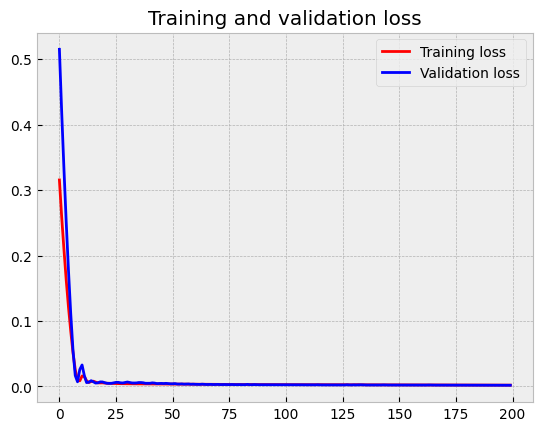

<Figure size 640x480 with 0 Axes>

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

In [ ]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

2/2 [==============================] - 0s 7ms/step


((184, 1), (34, 1))

#Model Evaluation

In [ ]:
# Transform back to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1))
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))

#Evaluation metrices RMSE, MSE and MAE

In [ ]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  10.892936629240722
Train data MSE:  118.65606840865424
Train data MAE:  8.678548564081607
-------------------------------------------------------------------------------------
Test data RMSE:  10.386724125268703
Test data MSE:  107.88403805443892
Test data MAE:  7.045885871438416


#Variance Regression Score

In [ ]:
print("Train data explained variance regression score:",
      explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:",
      explained_variance_score(original_ytest, test_predict))

Train data explained variance regression score: 0.9565272849500169
Test data explained variance regression score: 0.8609817293806232


#R square score for regression

In [ ]:
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

Train data R2 score: 0.9558779304521401
Test data R2 score: 0.8502013265534224


#Regression Loss Mean Gamma deviance regression loss (MGD) and Mean Poisson deviance regression loss (MPD)

In [ ]:
print("Train data MGD: ", mean_gamma_deviance(original_ytrain, train_predict))
print("Test data MGD: ", mean_gamma_deviance(original_ytest, test_predict))
print("----------------------------------------------------------------------")
print("Train data MPD: ", mean_poisson_deviance(original_ytrain, train_predict))
print("Test data MPD: ", mean_poisson_deviance(original_ytest, test_predict))

Train data MGD:  0.0010254884774468908
Test data MGD:  0.0006204131474087023
----------------------------------------------------------------------
Train data MPD:  0.34463661254498845
Test data MPD:  0.2583716902800775


#Comparision of original Nitflix close price and predicted close price

In [ ]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': close_stock['Date'],
                       'original_close': close_stock['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (250, 1)
Test predicted data:  (250, 1)


#Predicting next 30 days

In [ ]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 30
while(i<pred_days):

    if(len(temp_input)>time_step):

        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))

        yhat = model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)

        lst_output.extend(yhat.tolist())
        i=i+1

    else:

        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())

        lst_output.extend(yhat.tolist())
        i=i+1

print("Output of predicted next days: ", len(lst_output))

Output of predicted next days:  30


#Plotting last 15 days of dataset and next predicted 30 days

In [ ]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39
 40 41 42 43 44 45]


In [ ]:
temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat

last_original_days_value[0:time_step+1] = scaler.inverse_transform(closedf[len(closedf)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]

new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})

names = cycle(['Last 15 days close price','Predicted next 30 days close price'])

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'],
                                                      new_pred_plot['next_predicted_days_value']],
              labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Compare last 15 days vs next 30 days',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')

fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()



#Plotting entire Closing Stock Price with next 30 days period of prediction

In [ ]:
lstmdf=closedf.tolist()
lstmdf.extend((np.array(lst_output).reshape(-1,1)).tolist())
lstmdf=scaler.inverse_transform(lstmdf).reshape(1,-1).tolist()[0]

names = cycle(['Close price'])

fig = px.line(lstmdf,labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Plotting whole closing stock price with prediction',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Stock')

fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

#Feature Predicted Price 30 day

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
plt.style.use("bmh")

In [ ]:
#df = yf.download("NFLX",start="2023-02-19" ,end="2023-10-14")
df = yf.download("NFLX")#,interval="1m")

[*********************100%%**********************]  1 of 1 completed


In [ ]:
df.to_csv("NFLX.csv")

In [ ]:
df = pd.read_csv("NFLX.csv")

In [ ]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2002-05-23,1.156429,1.242857,1.145714,1.196429,1.196429,104790000
1,2002-05-24,1.214286,1.225000,1.197143,1.210000,1.210000,11104800
2,2002-05-28,1.213571,1.232143,1.157143,1.157143,1.157143,6609400
3,2002-05-29,1.164286,1.164286,1.085714,1.103571,1.103571,6757800
4,2002-05-30,1.107857,1.107857,1.071429,1.071429,1.071429,10154200
...,...,...,...,...,...,...,...
5384,2023-10-12,366.480011,368.829987,359.049988,361.200012,361.200012,7376100
5385,2023-10-13,355.640015,358.929993,352.049988,355.679993,355.679993,6312600
5386,2023-10-16,356.209991,363.079987,354.769989,360.820007,360.820007,5128900
5387,2023-10-17,361.100006,362.700012,353.890015,355.720001,355.720001,5908400


In [ ]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2002-05-23,1.156429,1.242857,1.145714,1.196429,1.196429,104790000
1,2002-05-24,1.214286,1.225000,1.197143,1.210000,1.210000,11104800
2,2002-05-28,1.213571,1.232143,1.157143,1.157143,1.157143,6609400
3,2002-05-29,1.164286,1.164286,1.085714,1.103571,1.103571,6757800
4,2002-05-30,1.107857,1.107857,1.071429,1.071429,1.071429,10154200


In [ ]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
5384,2023-10-12,366.480011,368.829987,359.049988,361.200012,361.200012,7376100
5385,2023-10-13,355.640015,358.929993,352.049988,355.679993,355.679993,6312600
5386,2023-10-16,356.209991,363.079987,354.769989,360.820007,360.820007,5128900
5387,2023-10-17,361.100006,362.700012,353.890015,355.720001,355.720001,5908400
5388,2023-10-18,351.000000,354.790009,344.730011,346.190002,346.190002,11168800


In [ ]:
df1=df.reset_index()['Close']

In [ ]:
df1

0         1.196429
1         1.210000
2         1.157143
3         1.103571
4         1.071429
           ...    
5384    361.200012
5385    355.679993
5386    360.820007
5387    355.720001
5388    346.190002
Name: Close, Length: 5389, dtype: float64

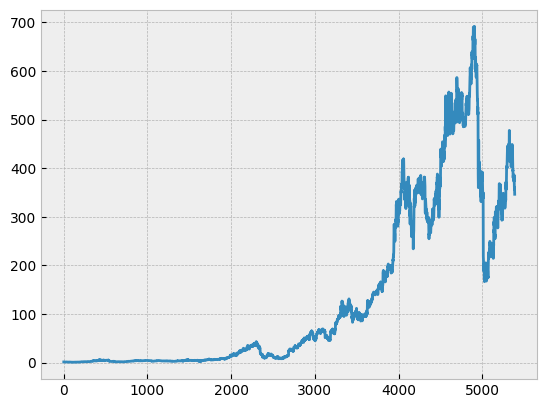

In [ ]:
import matplotlib.pyplot as plt
plt.plot(df1)

In [ ]:
### LSTM are sensitive to the scale of the data. so we apply MinMax scaler
import numpy as np

In [ ]:
df1

0         1.196429
1         1.210000
2         1.157143
3         1.103571
4         1.071429
           ...    
5384    361.200012
5385    355.679993
5386    360.820007
5387    355.720001
5388    346.190002
Name: Close, Length: 5389, dtype: float64

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [ ]:
print(df1)

[[0.00119131]
 [0.00121094]
 [0.00113448]
 ...
 [0.52139189]
 [0.51401466]
 [0.50022938]]


In [ ]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.80)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [ ]:
training_size,test_size


(4311, 1078)

In [ ]:
train_data

array([[0.00119131],
       [0.00121094],
       [0.00113448],
       ...,
       [0.54993158],
       [0.54358141],
       [0.54903475]])

In [ ]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [ ]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
print(X_train.shape), print(y_train.shape)

(4210, 100)
(4210,)


(None, None)

In [ ]:
print(X_test.shape), print(ytest.shape)

(977, 100)
(977,)


(None, None)

In [ ]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [ ]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [ ]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
# powerfull  this code
'''from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam  # Add this import

model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(100, 1)))
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(100))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))  # Adding dropout for regularization
model.add(Dense(1))

# Customizing the learning rate of the Adam optimizer
custom_optimizer = Adam(learning_rate=0.001)
model.compile(loss='mean_squared_error', optimizer=custom_optimizer)

# Print the model summary for better understanding
model.summary()
'''


"from keras.models import Sequential\nfrom keras.layers import LSTM, Dense, Dropout\nfrom keras.optimizers import Adam  # Add this import\n\nmodel = Sequential()\nmodel.add(LSTM(100, return_sequences=True, input_shape=(100, 1)))\nmodel.add(LSTM(100, return_sequences=True))\nmodel.add(LSTM(100))\nmodel.add(Dense(50, activation='relu'))\nmodel.add(Dropout(0.2))  # Adding dropout for regularization\nmodel.add(Dense(1))\n\n# Customizing the learning rate of the Adam optimizer\ncustom_optimizer = Adam(learning_rate=0.001)\nmodel.compile(loss='mean_squared_error', optimizer=custom_optimizer)\n\n# Print the model summary for better understanding\nmodel.summary()\n"

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 100, 50)           10400     
                                                                 
 lstm_4 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50851 (198.64 KB)
Trainable params: 50851 (198.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 100, 50)           10400     
                                                                 
 lstm_4 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50851 (198.64 KB)
Trainable params: 50851 (198.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
66/66 [==============================] - 7s 36ms/step - loss: 0.0019 - val_loss: 0.0030
Epoch 2/100
66/66 [==============================] - 1s 18ms/step - loss: 1.4606e-04 - val_loss: 0.0029
Epoch 3/100
66/66 [==============================] - 1s 21ms/step - loss: 1.5177e-04 - val_loss: 0.0032
Epoch 4/100
66/66 [==============================] - 1s 20ms/step - loss: 1.5208e-04 - val_loss: 0.0024
Epoch 5/100
66/66 [==============================] - 1s 15ms/step - loss: 1.2625e-04 - val_loss: 0.0032
Epoch 6/100
66/66 [==============================] - 1s 15ms/step - loss: 1.1885e-04 - val_loss: 0.0045
Epoch 7/100
66/66 [==============================] - 1s 15ms/step - loss: 1.2032e-04 - val_loss: 0.0021
Epoch 8/100
66/66 [==============================] - 1s 14ms/step - loss: 1.1933e-04 - val_loss: 0.0030
Epoch 9/100
66/66 [==============================] - 1s 15ms/step - loss: 1.0902e-04 - val_loss: 0.0017
Epoch 10/100
66/66 [==============================] - 1s 16ms/step -

In [ ]:
import tensorflow as tf

In [ ]:
import tensorflow as tf
tf.__version__

'2.13.0'

In [ ]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

31/31 [==============================] - 0s 6ms/step


In [ ]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [ ]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

115.01317237106362

In [ ]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

419.67227337929745

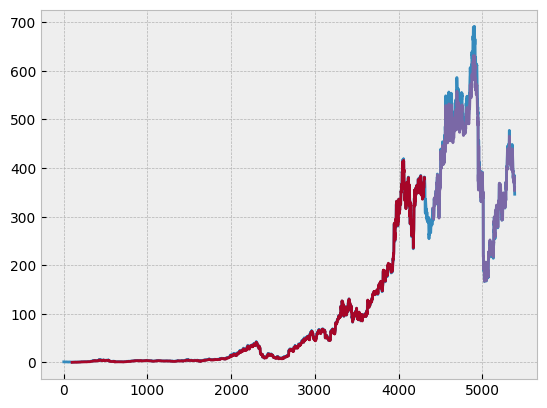

In [ ]:
### Plotting
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [ ]:
len(test_data)

1078

In [ ]:
x_input=test_data[978:].reshape(1,-1)
x_input.shape

(1, 100)

In [ ]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [ ]:
temp_input

[0.5475159272075377,
 0.5679117848780467,
 0.5711664416081033,
 0.5825938941870358,
 0.578746161377765,
 0.5831869702662501,
 0.5770392853316989,
 0.577733583848549,
 0.5916201280589449,
 0.6070254944190577,
 0.6127392427805776,
 0.6297502627491206,
 0.6371708430125994,
 0.6435499755008031,
 0.6242968763314195,
 0.6282603549895701,
 0.6134335854415349,
 0.6105839508943433,
 0.6128115508280471,
 0.6011237363052958,
 0.6027727394269219,
 0.6212302734977123,
 0.6189158421052952,
 0.636635639857825,
 0.638009845912603,
 0.644461286448276,
 0.6342489004179384,
 0.6331784941083897,
 0.6384003888283311,
 0.6362306176749601,
 0.6417852265302971,
 0.6509416855182227,
 0.6386897093064234,
 0.6504643111437811,
 0.6862655351744028,
 0.6903013218800229,
 0.6321948751134472,
 0.6178454357957464,
 0.6191038960016444,
 0.6181347562738387,
 0.6108587921052988,
 0.5971169081339491,
 0.6153574297741167,
 0.6344369543142877,
 0.6339306655496797,
 0.6210277844783335,
 0.622908235153612,
 0.6237761524437819

In [ ]:
#this code is rong
# demonstrate prediction for next 10 days
'''from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


print(lst_output)'''

'from numpy import array\n\nlst_output=[]\nn_steps=100\ni=0\nwhile(i<30):\n    \n    if(len(temp_input)>100):\n        #print(temp_input)\n        x_input=np.array(temp_input[1:])\n        print("{} day input {}".format(i,x_input))\n        x_input=x_input.reshape(1,-1)\n        x_input = x_input.reshape((1, n_steps, 1))\n        #print(x_input)\n        yhat = model.predict(x_input, verbose=0)\n        print("{} day output {}".format(i,yhat))\n        temp_input.extend(yhat[0].tolist())\n        temp_input=temp_input[1:]\n        #print(temp_input)\n        lst_output.extend(yhat.tolist())\n        i=i+1\n    else:\n        x_input = x_input.reshape((1, n_steps,1))\n        yhat = model.predict(x_input, verbose=0)\n        print(yhat[0])\n        temp_input.extend(yhat[0].tolist())\n        print(len(temp_input))\n        lst_output.extend(yhat.tolist())\n        i=i+1\n    \n\nprint(lst_output)'

In [ ]:
import numpy as np

lst_output = []
n_steps = 100
i = 0

while i < 30:
    if len(temp_input) > n_steps:
        x_input = np.array(temp_input[-n_steps:]).reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)

        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]

        lst_output.extend(yhat.tolist())

        print("{} day input {}".format(i, x_input.flatten()))
        print("{} day output {}".format(i, yhat.flatten()))

        i += 1
    else:
        x_input = np.array(temp_input).reshape((1, len(temp_input), 1))
        yhat = model.predict(x_input, verbose=0)

        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())

        print("{} day input {}".format(i, x_input.flatten()))
        print("{} day output {}".format(i, yhat.flatten()))

        i += 1

print(lst_output)


0 day input [0.54751593 0.56791178 0.57116644 0.58259389 0.57874616 0.58318697
 0.57703929 0.57773358 0.59162013 0.60702549 0.61273924 0.62975026
 0.63717084 0.64354998 0.62429688 0.62826035 0.61343359 0.61058395
 0.61281155 0.60112374 0.60277274 0.62123027 0.61891584 0.63663564
 0.63800985 0.64446129 0.6342489  0.63317849 0.63840039 0.63623062
 0.64178523 0.65094169 0.63868971 0.65046431 0.68626554 0.69030132
 0.63219488 0.61784544 0.6191039  0.61813476 0.61085879 0.59711691
 0.61535743 0.63443695 0.63393067 0.62102778 0.62290824 0.62377615
 0.63702623 0.63346777 0.61987055 0.62143281 0.6093978  0.61825046
 0.6123487  0.60041496 0.58240584 0.58461901 0.59005791 0.59711691
 0.61791774 0.58809063 0.60125392 0.60419034 0.62144724 0.62821696
 0.62678488 0.63575329 0.64848259 0.6442588  0.64046894 0.63997708
 0.64368016 0.62824588 0.59577162 0.57877508 0.57363997 0.56996581
 0.57256956 0.55824904 0.55513904 0.54886117 0.55607927 0.54805113
 0.54564991 0.54387068 0.54566439 0.54961335 0.544

In [ ]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
len(df1)

5389

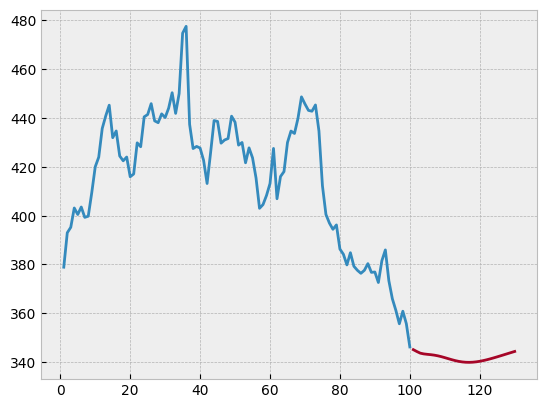

In [ ]:
plt.plot(day_new,scaler.inverse_transform(df1[5289:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

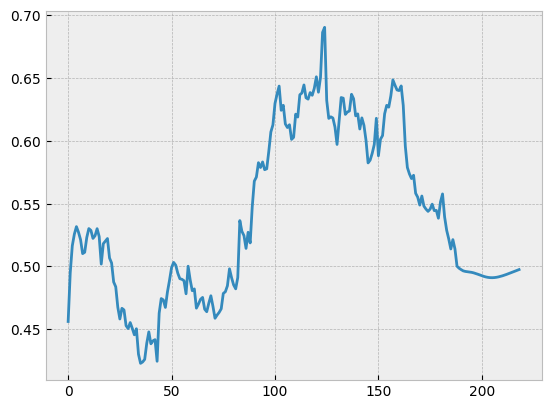

In [ ]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[5200:])

In [ ]:
df3=scaler.inverse_transform(df3).tolist()

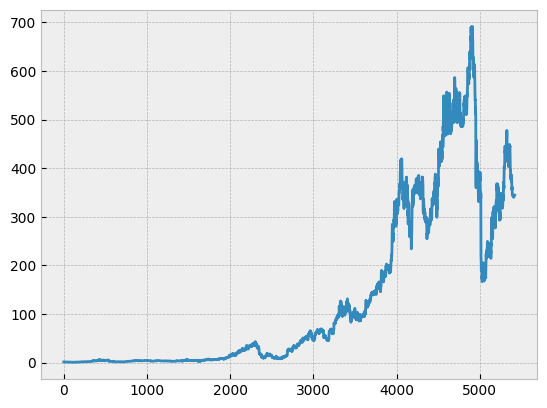

In [ ]:
plt.plot(df3)
